# Agent Models Creation

In [1]:
import matplotlib.pyplot as plt

from mesa import Agent, Model

from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import MultiGrid

import numpy as np
import random

%matplotlib inline

In [2]:
batch_run_bool = 0

def average_age(model):
    """Calculate the average age of the population"""
    agent_age = []
    for agent in model.schedule.agents:
        if agent.health > 0:
            agent_age.append(agent.age)
    N = model.num_agents
    if len(agent_age) > 0:
        B = sum(agent_age)/len(agent_age)
        return B # (1 + (1/(N+1)) - 2*B)
    else:
        return 0

# Health has 4 states: 
#     0 - Dead; 
#     1 - infected; 
#     2 - healthy (no anti-bodies); 
#     3 - healthy (anti-bodies)

class InfectedAgent(Agent):
    """Initializing an agent with health state '2' and random age."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 2
        
        # Age is a big role in survival, as people age their immune system weakens
        # These are percentage values of survival probability.
        self.age = random.randint(1, 86)
        if self.age < 40:
            self.survival = 99
        elif self.age <= 60:
            self.survival = 90
        elif self.age > 60:
            self.survival = 15
        self.infect_day_count = 0

    def move(self):
        # 2 ways to get neighbors: 
        #     Moore - 8 surrounding cells; 
        #     Von Neumann - Only XY axis.
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center = False,
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
            
    def infect(self):
        """Spreading the infect to cellmates"""
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            for cellmate in cellmates:
                if self.health == 1 and cellmate.health == 2: 
                    cellmate.health = self.health
                elif self.health == 2 and cellmate.health == 1:
                    self.health = cellmate.health
                    self.immunity()
                elif self.health == 1 and cellmate.health == 1:
                    self.immunity()
    
    def immunity(self):
        if self.health == 1:            
            # Random roll of fate whether one survives or not.
            # Probability of survival helps
            if self.survival < random.randint(1, 100):
                self.health = 0
                
            # Survive for 14 days and you're considered 'immmune'.
            self.infect_day_count += 1
            if self.infect_day_count == 14:
                self.health = 3        
        
    def step(self):
        # Make the agent move in environment by 1 step.
        if self.health != 0:
            self.move()
        # Spreading (1) or catching (2) the infection
        if self.health == 1 or self.health == 2:
            self.infect()

class InfectionModel(Model):
    """Declaring the model environment with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = InfectedAgent(i, self)
            self.schedule.add(a)

            # Assign the agents to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters={"Average Age": average_age},
            agent_reporters={"Health": "health"},
        )
        pz = random.choice(list(self.schedule.agents))
        pz.health = 1
                
    def step(self):
        '''Advance the model by one step'''
        self.datacollector.collect(self)
        self.schedule.step()

# Running basic models

(array([4., 0., 0., 0., 0., 0., 0., 0., 0., 6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

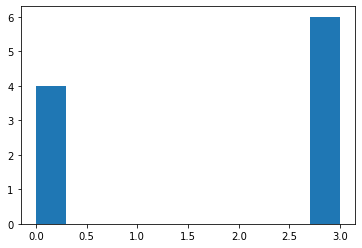

In [3]:
import numpy as np
""" Single run of the agents to show the process """
model = InfectionModel(10, 1, 1)
for i in range(10):
    model.step()

agent_health = [a.health for a in model.schedule.agents]
plt.hist(agent_health)

(array([521.,   3., 476.]), array([0, 1, 2, 3]), <a list of 3 Patch objects>)

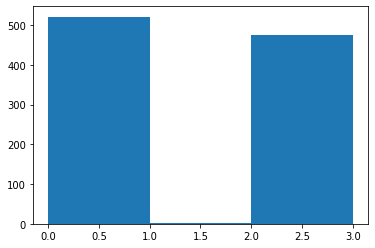

In [4]:
"""Cycling the agents through multiple iterations to show where the infection is going"""
all_health = []
# Running the model 100 times, each model executing 10 steps 
for j in range(100):
    # Run the model
#     print(f"Model run number {j+1}")
    model = InfectionModel(10, 1, 1)
    for i in range(10):
        model.step()
    
    # Storing the results
    for agent in model.schedule.agents:
        all_health.append(agent.health)

plt.hist(all_health, bins=range(max(all_health)+1))

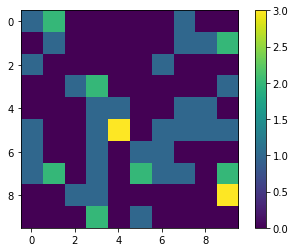

In [5]:
"""Running a 2x2 instance of the matrix to show how neighbors are affected"""
model = InfectionModel(50, 10, 10)
for i in range(100):
    model.step()

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()


    Grabbing the Agent health data

                  Health
Step AgentID        
0    0             2
     1             2
     2             2
     3             2
     4             2
    


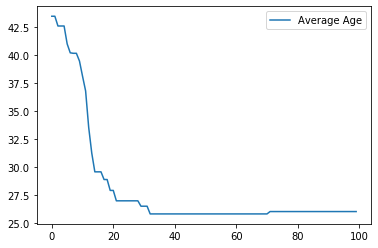

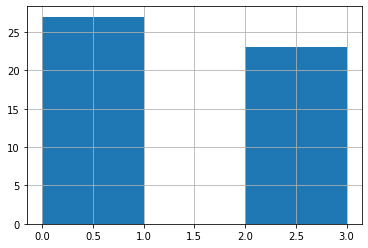

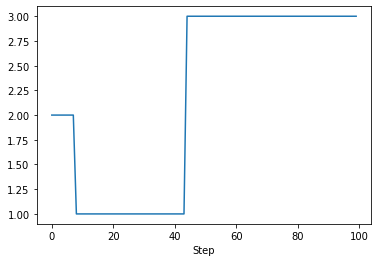

In [6]:
"""Running Data Collection and the Gini function to show a plot of income disparity over steps"""
model = InfectionModel(50, 10, 10)
for i in range(100):
    model.step()
agent_health = model.datacollector.get_agent_vars_dataframe()
print(f"""
    Grabbing the Agent health data

    {agent_health.head()}
    """)
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.show()
end_health = agent_health.xs(99, level="Step")["Health"]
end_health.hist(bins=range(agent_health.Health.max()+1))
plt.show()
one_agent_health = agent_health.xs(14, level="AgentID")
one_agent_health.Health.plot()

In [7]:
"""
    Running app as a batch command. 
    This will plot a scatter chart of 5 points per column as per iterations for each gini result.
"""
fixed_params = {
    "width": 10,
    "height": 10,
}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(
    InfectionModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=50,
    model_reporters={"Average Age": average_age},
)
if batch_run_bool: # Boolean at the top to prevent this from running
    batch_run.run_all()
    run_data = batch_run.get_model_vars_dataframe()
    print(f"""The head of the data is 

        {run_data.head()}
    """)
    plt.scatter(run_data.N, run_data.Gini)

# Running the view application included with Mesa library 

In [8]:
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer, VisualizationElement

In [9]:
def agent_portrayal(agent):
#     portrayal = {"Shape": "circle",
#                  "Filled": "true",
#                  "Layer": 0,
#                  "Color": "red",
#                  "r": 0.5}
#     return portrayal
    portrayal = {
        "Shape": "circle",
        "Filled": "true",
    }
    if agent.health == 0:
        portrayal["Color"] = "black"
        portrayal["Layer"] = 3
        portrayal["r"] = 0.25
        
    elif agent.health == 1:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 2
        portrayal["r"] = 0.5
        
    elif agent.health == 2:
        portrayal["Color"] = "yellow"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.75
        
    elif agent.health == 3:
        portrayal["Color"] = "green"
        portrayal["Layer"] = 0
        portrayal["r"] = 1.0
    return portrayal

In [10]:
"""Creating a custom visualization"""
class HistogramModuleHealth(VisualizationElement):
    package_includes = ["Chart.min.js"]
    local_includes = ["HistogramModule.js"]

    def __init__(self, bins, canvas_height, canvas_width):
        self.canvas_height = canvas_height
        self.canvas_width = canvas_width
        self.bins = bins
        new_element = "new HistogramModule({}, {}, {})"
        new_element = new_element.format(bins,
                                         canvas_width,
                                         canvas_height)
        self.js_code = "elements.push(" + new_element + ");"

    def render(self, model):
        health_vals = [agent.health for agent in model.schedule.agents]
        hist = np.histogram(health_vals, bins=self.bins)[0]
        return [int(x) for x in hist]
    
class HistogramModuleAge(VisualizationElement):
    package_includes = ["Chart.min.js"]
    local_includes = ["HistogramModule.js"]

    def __init__(self, bins, canvas_height, canvas_width):
        self.canvas_height = canvas_height
        self.canvas_width = canvas_width
        self.bins = bins
        new_element = "new HistogramModule({}, {}, {})"
        new_element = new_element.format(bins,
                                         canvas_width,
                                         canvas_height)
        self.js_code = "elements.push(" + new_element + ");"

    def render(self, model):
        age_vals = []
        for agent in model.schedule.agents:
            if agent.health > 0: 
                age_vals.append(agent.age)
        hist = np.histogram(age_vals, bins=self.bins)[0]
        return age_vals # [int(x) for x in hist]

In [11]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

# server = ModularServer(InfectionModel,
#                        [grid],
#                        "Infection Model",
#                        {"N":100, "width":10, "height":10})

chart = ChartModule([{"Label": "Average Age",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

histogram = HistogramModuleHealth(list(range(10)), 200, 500)

histogramAge = HistogramModuleAge(list(range(10)), 200, 500)

server = ModularServer(InfectionModel,
                       [grid, chart, histogram, histogramAge],
                       "Infection Model",
                       {"N":100, "width":10, "height":10})

# server.port = 8521 # This is the default value
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step